### About the PDF report
Sometimes the PDF report will generate and have strange line breaks. If this happens, just rereun the single cell towards the end of this script, under the section header titled "PDF Start"

### Change this stuff

In [1]:
# Do you want to run the script and generate this stuff?
# The script will run regardless of what you choose here
# choose "yes" or "no"
workbook_close = 'yes'
pdf_write = 'yes'

### Libraries

In [2]:
import os
tilde = os.path.expanduser('~')

import sys
sys.path.insert(0, tilde + '/Scripts/Fake Folder/Python Libraries')

from jb_libraries import *
%matplotlib inline

### Script settings

In [3]:
# get the current date
now = dt.datetime.now()
pretty_now = str(dt.datetime.now().date())

# the weeks in this report begin on wednesday and end on thursday
# here, get the current date, if it's not a thursday, back up to the most recent thursday
d = dt.datetime.now()
i = 0
while d.strftime('%A').lower() != 'thursday':
    d = (now - pd.DateOffset(days = i))
    i += 1
else:
    week_end = str(d.date())

csv_path = tilde + '/Scripts/Fake Folder/Fab/Recurring/Fab Op Report/CSVs/'

image_path = tilde + '/Scripts/Fake Folder/Fab/Recurring/Fab Op Report/Images/'

html_path = tilde + '/Scripts/Fake Folder/Fab/Recurring/Fab Op Report/HTML/'
html_title = 'Fab Op Report.html'

pdf_path = tilde + '/Scripts/Fake Folder/Fab/Recurring/Fab Op Report/Docs/Weekly Reports/'

style_sheet_path = tilde + '/Scripts/Fake Folder/CSS Stylesheets/Recurring Reports Stylesheet.css'

report_dict = {}

workbook_title = 'Fab Op Metric data as of ' + week_end

### Get Fab data

In [4]:
from fab_data import *


== fab_data start ==

WO date nulls even though WO is marked as "completed":
created
0
scheduled
0
active
52
completed
8
these are stored in the "date_nulls" df and have been fixed

The data shows the following work order counts:

x6,708 unique
x6,176 completed
x214 open
x318 pending

your df is called "fab_data_main"


== fab_data end ==



### Chart settings

In [5]:
colors = ['#f2f7f8',
          '#3f312d',
          '#c9cdc7',
          '#3a6e7c',
          '#84b4c0',
          '#364345']

### Work Order Counts

In [6]:
counts = fab_data_main.groupby('wo status')[['wo id']].nunique()
counts.columns = ['work order counts']
counts.sort_values('work order counts', ascending = False, inplace = True)

counts.loc['Total'] = counts.sum()
counts.reset_index(inplace = True)
counts['wo status'] = [x.title() for x in counts['wo status']]

fmt = [0,'n0']
display(counts.format_(fmt))
report_dict['summary - work order counts'] = counts.format_(fmt).to_html(index = False)

,Wo Status,Work Order Counts
0,Completed,"6,176"
1,Pending,318
2,Active,214
3,Total,"6,708"


# Begin to assemble the Fab Op Metric
Recall that this metric covers:
* work order completion
* quality
* reworks
* in-stock percentage

In what follows we'll get all four parts and put them altogether along with their weights to create the Fab Op Metric.

# Work Order Creation and Completion
### a.k.a. Availability Metric
 Availability = (50%)(WOs completed / scheduled) + (50%)(WOs completed / active)

In [7]:
avail_main = fab_data_main[fab_data_main['wo outsourced'] == 'no'].drop_duplicates('wo id', keep = 'first').copy()

### For reports

In [8]:
# group on these columns to get the work order count per week
df1 = avail_main.groupby('wo week scheduled')[['wo id']].count()
df1.columns = ['scheduled']

df2 = avail_main.groupby('wo week active')[['wo id']].count()
df2.columns = ['active']

df3 = avail_main.groupby('wo week completed')[['wo id']].count()
df3.columns = ['completed']

# join them all
df4 = df1.join(df2).join(df3)

# make these columns
df4['completed as % of scheduled'] = df4['completed']/df4['scheduled']
df4['completed as % of active'] = df4['completed']/df4['active']

# get all active WOs
df5 = avail_main[avail_main['wo status'] == 'active'].groupby('wo week scheduled')[['wo id']].nunique()    
df5.columns = ['active wos']

# join
avail = df4.join(df5)
avail.fillna(0, inplace = True)
avail = avail[avail.index <= week_end]

# this is the Availability metric of the Fab Op Metric
w1 = 0.50
w2 = 1 - w1
avail['availability %'] = w1 * avail['completed as % of scheduled'] + w2 * avail['completed as % of active']

### Availability Summary

In [9]:
# a function that I wrote which takes in a dataframe, finds the mean, then formats the 
    # output according to the list that was passed in
fmt = ['n0'] * 3 + ['p1'] * 2 + ['n0','p1']
print(jb_mean(avail.iloc[-53:], fmt))

avail.tail(8).format_(fmt)

                              mean
Scheduled                       24
Active                          24
Completed                       22
Completed As % Of Scheduled  97.7%
Completed As % Of Active     96.5%
Active Wos                       4
Availability %               97.1%


,Scheduled,Active,Completed,Completed As % Of Scheduled,Completed As % Of Active,Active Wos,Availability %
wo week scheduled,,,,,,,
2019-05-09,30,29,45,150.0%,155.2%,12,152.6%
2019-05-16,26,27,24,92.3%,88.9%,13,90.6%
2019-05-23,28,26,31,110.7%,119.2%,23,115.0%
2019-05-30,15,15,6,40.0%,40.0%,9,40.0%
2019-06-06,25,24,17,68.0%,70.8%,11,69.4%
2019-06-13,27,27,20,74.1%,74.1%,19,74.1%
2019-06-20,33,35,23,69.7%,65.7%,28,67.7%
2019-06-27,35,33,24,68.6%,72.7%,30,70.6%


### Availability plot

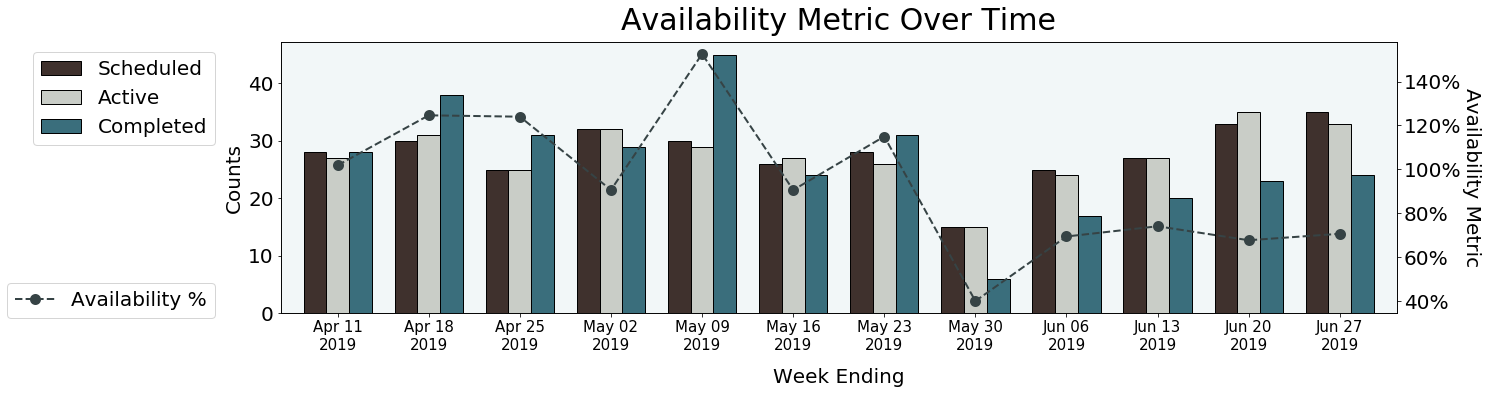

In [10]:
chart = avail.tail(12).copy() # plot just the most recent 16 weeks
fig, ax = plt.subplots(figsize = (20,5))

chart[['scheduled','active','completed']].plot(kind = 'bar',
                                              ax = ax,
                                              color = colors[1:4],
                                              edgecolor = 'black',
                                              width = 0.75)

ax.set_title('Availability Metric Over Time', fontsize = 30, y = 1.02)
ax.set_yticklabels(['{:,.0f}'.format(x) for x in ax.get_yticks()], fontsize = 20)
ax.set_ylabel('Counts', fontsize = 20)
ax.set_xlabel('Week Ending',fontsize = 20, labelpad = 15)
ax.legend(['Scheduled','Active','Completed'],fontsize = 20, bbox_to_anchor = (-0.05, 1))
ax.set_facecolor(colors[0])

ax2 = ax.twinx()
chart['availability %'].plot(ax = ax2,
                             ls = '--', 
                             lw = 2,
                             marker = 'o',
                             mew = 5,
                             color = colors[5])

ax2.set_yticklabels(['{:,.0f}%'.format(x * 100) for x in ax2.get_yticks()], fontsize = 20)
ax2.set_ylabel('Availability Metric', fontsize = 20, rotation = 270, labelpad = 20)

ls = [x.get_text() for x in ax.get_xticklabels()]
ls2 = jb_dates(pd.Series(ls), 'date xticks')
ax.set_xticklabels(ls2, fontsize = 15, rotation = 0)

ax2.legend(['Availability %'],fontsize = 20, bbox_to_anchor = (-0.05, 0.15))

plt.savefig(image_path + ax.get_title(), bbox_inches = 'tight')
plt.show()

# Quality
Quality = Good Units / Total Units

In [11]:
# get main data for this subsection
# exclude reworks
quality_main = fab_data_main[(fab_data_main['rework id'] == 0)].drop_duplicates('process id', keep = 'first').copy()

# get the count of rejects
df1 = quality_main.groupby(['process week end','process group'])[['process qty reject']].sum().unstack(1).fillna(0)
df1.columns = df1.columns.droplevel(0)
df1['total qty rejected'] = df1.sum(1)

# get total qty in
df2 = quality_main.groupby('process week end')[['process qty in']].sum()
df2.columns = ['total qty in']

# join the two
df3 = df1.join(df2)

# count how many steps ocurred in the manufacturing process
df4 = quality_main.groupby(['process week end','process group'])[['process group']].count().unstack(1).fillna(0)
df4.columns = df4.columns.droplevel(0)
df4['total steps'] = df4.sum(1)    

# join
df5 = df3.join(df4['total steps'])    

# get some stats
df5['reject %'] = df5['total qty rejected']/df5['total qty in']
df5['quality %'] = 1 - df5['reject %']

# get the unique work order count
df6 = quality_main.groupby('process week end')[['wo id']].nunique()
df6.columns = ['unique wo count']

# join
df7 = df5.join(df6)

# get the count for the fabrication step only
df8 = quality_main[quality_main['process group'] == 'fabricate'].groupby('process week end')[['process qty in']].sum()
df8.columns = ['fabrication qty in']

# join it and get machine_yield
df9 = df7.join(df8)
df9['machine yield'] = 1 - (df9['fabricate']/df9['fabrication qty in'])

qual = df9.copy()
qual = qual[qual.index <= week_end]

### Quality Summary

In [12]:
fmt = ['n0'] * 10 + ['p1'] * 2 + ['n0'] * 2 + ['p1']

print(jb_mean(qual.iloc[-53:], fmt))
      
qual.tail(8).format_(fmt)

                       mean
Fabricate               261
Kitten                   41
Outsource                 0
Prep                     12
Qa                        0
Secondary                 1
Test                    379
Total Qty Rejected      694
Total Qty In        107,688
Total Steps             126
Reject %               0.7%
Quality %             99.3%
Unique Wo Count          56
Fabrication Qty In   17,914
Machine Yield         98.5%


,Fabricate,Kitten,Outsource,Prep,Qa,Secondary,Test,Total Qty Rejected,Total Qty In,Total Steps,Reject %,Quality %,Unique Wo Count,Fabrication Qty In,Machine Yield
process week end,,,,,,,,,,,,,,,
2019-05-09,632,216,0,1,0,0,378,"1,227","216,483",216,0.6%,99.4%,83,"23,824",97.3%
2019-05-16,17,11,0,1,0,2,715,746,"110,120",134,0.7%,99.3%,59,"13,948",99.9%
2019-05-23,0,6,0,1,2,0,497,506,"301,889",169,0.2%,99.8%,73,"28,412",100.0%
2019-05-30,205,7,0,1,0,0,107,320,"32,714",61,1.0%,99.0%,30,"11,367",98.2%
2019-06-06,509,52,0,13,1,0,298,873,"79,622",105,1.1%,98.9%,46,"15,533",96.7%
2019-06-13,"1,505",1,0,0,1,20,649,"2,176","90,882",124,2.4%,97.6%,56,"21,703",93.1%
2019-06-20,140,10,0,6,0,0,189,345,"83,636",156,0.4%,99.6%,69,"17,759",99.2%
2019-06-27,493,13,0,9,1,2,606,"1,124","110,764",168,1.0%,99.0%,68,"16,629",97.0%


### Quality Plot

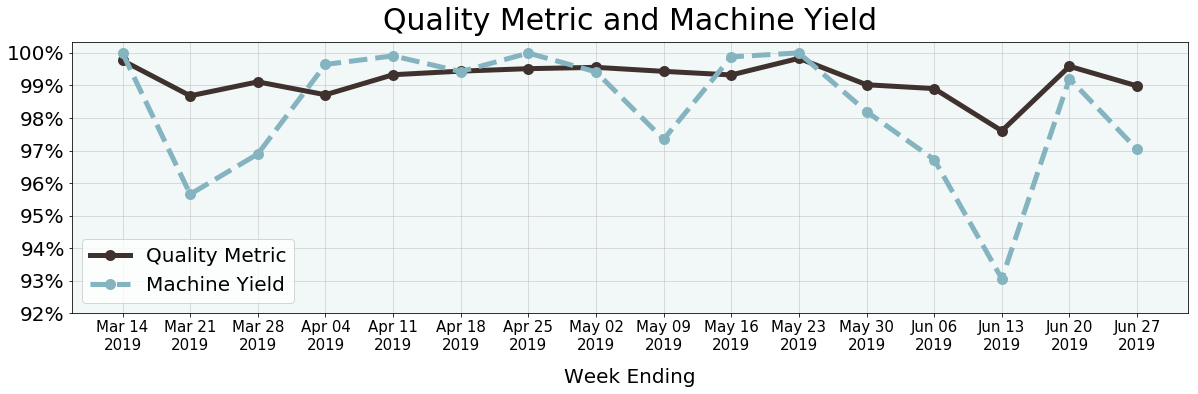

In [13]:
fig, ax = plt.subplots(figsize = (20,5))

n = 16 # plot the most recent 16 weeks
x = range(n)
y1 = qual['quality %'].tail(n)
y2 = qual['machine yield'].tail(n)

ax.plot(x, y1,
       lw = 5,
       marker = 'o',
       mew = 5,
       color = colors[1])

ax.plot(x, y2,
       lw = 5,
       ls = '--',
       marker = 'o',
       mew = 5,
       color = colors[4])

ax.set_xticks(x)
ls = list(qual.index[-n:])
ls2 = list(jb_dates(pd.Series(ls), 'date xticks'))
ax.set_xticklabels(ls2, fontsize = 15, rotation = 0)
ax.set_xlabel('Week Ending', fontsize = 20, labelpad = 15)

m1 = ax.get_yticks().min()
m2 = ax.get_yticks().max()
yticks = np.arange(m1, m2, 0.01)
ax.set_yticks(yticks)
ax.set_yticklabels(['{:,.0f}%'.format(x * 100) for x in ax.get_yticks()], fontsize = 20)

ax.set_title('Quality Metric and Machine Yield', fontsize = 30, y = 1.02)
ax.legend(['Quality Metric','Machine Yield'], fontsize = 20)
ax.set_facecolor(colors[0])
ax.grid(alpha = 0.5)

plt.savefig(image_path + ax.get_title(), bbox_inches = 'tight')
plt.show()

### Units rejected during the latest week
Zoom in to the current week to see which parts had the most rejections

In [14]:
rej1 = quality_main[quality_main['process week end'] == week_end].copy()

for col in ['part id','sku id']:
    rej1[col] = [int(x) for x in rej1[col]]
    
rej2 = rej1.groupby(['sku id','part id','products name','process group'])[['process qty reject']].sum().unstack(3).fillna(0)
rej2.columns = rej2.columns.droplevel(0)
rej2['row total'] = rej2.sum(1)
rej2 = rej2.drop(rej2[rej2['row total'] == 0].index)
rej2.sort_values('row total', ascending = False, inplace = True)

rej2.loc[('','','Column Total'),:] = rej2.sum()

t = rej2.iloc[-1]['row total']
print('Total units rejected: {:,.0f}'.format(t))
for col in rej2.columns:
    rej2[col] = [int(x) for x in rej2[col]]

display(rej2)    

Total units rejected: 1,124


/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py:399: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)


,,process group,fabricate,kitten,outsource,prep,qa,secondary,test,row total
sku id,part id,products name,,,,,,,,
8991,3178,Adafruit Feather M0 with RFM95 LoRa Radio - 900MHz,0,0,0,0,0,0,382,382
8965,3072,Adafruit RFM95W LoRa Radio Transceiver Breakout - 868 or 915 MHz,288,0,0,0,0,0,0,288
12807,3966,Adafruit BMP388 - Precision Barometric Pressure and Altimeter,120,0,0,0,0,0,22,142
13002,4062,Adafruit Feather nRF52840 Express,40,0,0,0,0,0,8,48
13429,4224,Adafruit eInk Breakout Friend with 32KB SRAM,30,0,0,0,0,0,0,30
8640,1963,Adafruit FONA - Mini Cellular GSM Breakout - SMA Version,0,0,0,0,0,0,28,28
8609,1867,12mm Coin Cell Breakout w/ On-Off Switch,0,0,0,0,0,0,26,26
13696,4285,Adafruit AirLift Shield - ESP32 WiFi Co-Processor,0,0,0,0,0,0,25,25
8662,2078,Adafruit PowerBoost 500 Shield - Rechargeable 5V Power Shield,0,0,0,0,0,0,21,21


### Z scores of rejected qty per step
Since the total number of units manufactured each week changes, we cannot directly compare the number of units rejected per week. We must put them all on the same footing, so to speak, and we will do this by getting their z scores before we compare them directly.

In [15]:
z = qual.iloc[:,:7]

mean = z.mean()
s = z.std()

z2 = (z - mean)/s

z2.tail(8).format_(['n2'] * len(z2.columns))

,Fabricate,Kitten,Outsource,Prep,Qa,Secondary,Test
process week end,,,,,,,
2019-05-09,1.06,0.33,-0.11,-0.29,-0.11,-0.13,-0.32
2019-05-16,-0.63,-0.18,-0.11,-0.29,-0.11,0.12,0.67
2019-05-23,-0.68,-0.19,-0.11,-0.29,-0.01,-0.13,0.03
2019-05-30,-0.12,-0.19,-0.11,-0.29,-0.11,-0.13,-1.12
2019-06-06,0.72,-0.08,-0.11,-0.17,-0.06,-0.13,-0.56
2019-06-13,3.46,-0.21,-0.11,-0.30,-0.06,2.43,0.48
2019-06-20,-0.30,-0.18,-0.11,-0.24,-0.11,-0.13,-0.88
2019-06-27,0.68,-0.18,-0.11,-0.21,-0.06,0.12,0.35


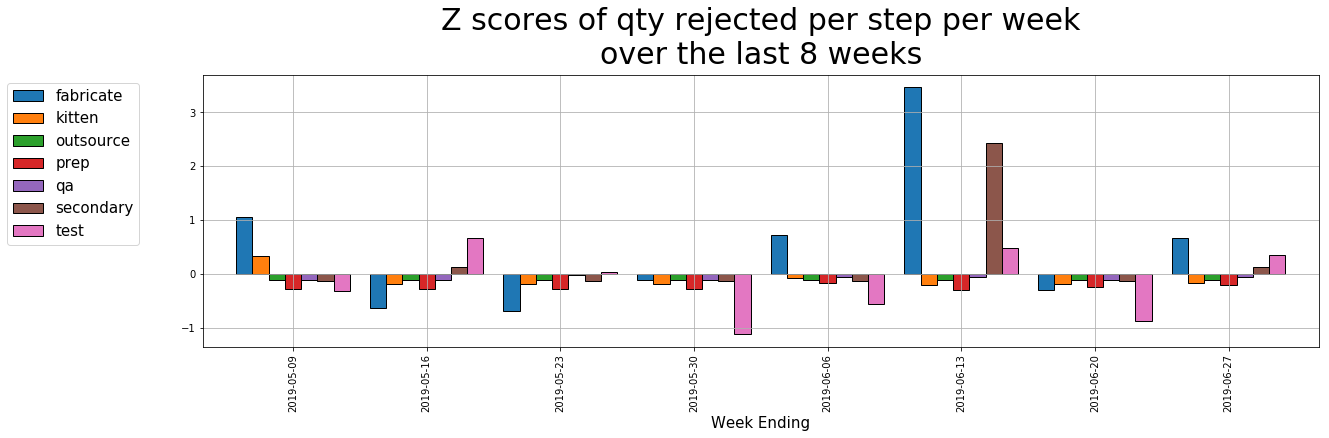

In [16]:
fig, ax = plt.subplots()
z2.tail(8).plot(kind = 'bar', 
                figsize = (20,5),
                ax = ax,
                width = .85,
                grid = True,
                edgecolor = 'black')
ax.legend(fontsize = 15, bbox_to_anchor = (-0.05, 1))
ax.set_xlabel('Week Ending', fontsize = 15)
ax.set_title('Z scores of qty rejected per step per week\nover the last 8 weeks', fontsize = 30, y = 1.02)
plt.show()

### Rejections with high z scores

In [17]:
ls = z2.iloc[-1][z2.iloc[-1] > 0.5].index.tolist() # take a closer look at those steps with rejections that are one-half of a stand dev above the mean

if len(ls) > 0:
    a = rej1[(rej1['process group'].isin(ls)) & (rej1['process qty reject'] > 0)]

    b = a.groupby(['process group','part id','wo id'])[['process qty reject']].sum()
    b.reset_index(inplace = True)
    b.sort_values('process qty reject', ascending = False, inplace = True)

    c = pd.DataFrame()
    for p in set(b['process group']):
        df = b[b['process group'] == p].copy()
        q = df['process qty reject'].quantile(0.85)
        df.drop(df[df['process qty reject'] < q].index, inplace = True)
        c = c.append(df, ignore_index = True)

    c['process group'] = c['process group'].str.title()    
    c.set_index(['process group','part id','wo id'], inplace = True)
    c.rename(columns = {'process qty reject':'count of rejections'}, inplace = True)
    c.columns = c.columns.str.title()
    names = list(c.index.names)
    names = [x.title() for x in names]
    c.index.names = names

    s = len(set(b['part id']))
    if s == 1:
        w2 = 'work order is'
    elif s > 1:
        w2 = 'work orders are'
    else:
        pass

    if len(ls) == 1:
        wrt = 'On a step-by-step basis, the {} step incurred some higher than normal rejections. The problematic {} shown in the table below.'.format(ls[0].title(), w2)
    else:
        w3 = ''
        max_ = len(ls) - 1
        for i in range(len(ls)):
            if i != max_:
                w3 += ls[i].title() + ', '
            else:
                w3 += 'and ' + ls[i].title()    
        wrt = 'On a step-by-step basis, the {} steps incurred some higher than normal rejections. The problematic {} shown in the table below.'.format(w3, w2)

    report_dict['quality - high rejection write'] = wrt + '\n' + c.to_html(index = True)
    
else:
    report_dict['quality - high rejection write'] = 'On a step-by-step basis, all rejections counts were below or at their averages.'

# Rework
Rework = Successful Reworks / Total Reworks Attempted

In [18]:
# get main subset
reworks_main = fab_data_main[(fab_data_main['rework id'] > 0) & (fab_data_main['wo status'] == 'completed')].copy()
reworks_main['part id'] = [int(x) for x in reworks_main['part id']]

# get some rework qty data
df1 = reworks_main.groupby('spa week end')[['spa qty in','spa qty out','spa qty reject']].sum()
df1.columns = ['qty attempted','qty out','qty rejected']

# create empty weeks if no reworks were performed
start = df1.index[0]
end = week_end

ix = pd.date_range(start, end, freq = 'D')
ix2 = ix[np.arange(0,len(ix),7)]
ds = pd.DataFrame(index = ix2)
ds.index.names = ['spa week end']
df1 = ds.join(df1)

# get total available to rework
df2 = qual[['total qty rejected']]
df2.columns = ['total qty available']

# join
df3 = df1.join(df2)

# get unique work order count
df4 = reworks_main.groupby('spa week end')[['rework id']].nunique()
df4.columns = ['unique wo count']

# join
df5 = df3.join(df4)

# get these stats
df5['attempted as % of available'] = df5['qty attempted']/df5['total qty available']
df5['reject %'] = df5['qty rejected']/df5['qty attempted']
df5['success %'] = 1 - df5['reject %']
df5.fillna(0, inplace = True)

rework = df5.copy()

### Rework summary

In [19]:
fmt = ['n0'] * 5 + ['p1'] * 3
print(jb_mean(rework.iloc[-53:], fmt))

rework.tail(8).format_(fmt)

                              mean
Qty Attempted                  301
Qty Out                        110
Qty Rejected                   191
Total Qty Available            694
Unique Wo Count                 15
Attempted As % Of Available  50.2%
Reject %                     46.0%
Success %                    44.6%


,Qty Attempted,Qty Out,Qty Rejected,Total Qty Available,Unique Wo Count,Attempted As % Of Available,Reject %,Success %
spa week end,,,,,,,,
2019-05-09,53,0,53,"1,227",2,4.3%,100.0%,0.0%
2019-05-16,30,0,30,746,2,4.0%,100.0%,0.0%
2019-05-23,30,0,30,506,1,5.9%,100.0%,0.0%
2019-05-30,57,45,12,320,3,17.8%,21.1%,78.9%
2019-06-06,0,0,0,873,0,0.0%,0.0%,0.0%
2019-06-13,762,8,754,"2,176",77,35.0%,99.0%,1.0%
2019-06-20,298,279,19,345,7,86.4%,6.4%,93.6%
2019-06-27,636,587,49,"1,124",12,56.6%,7.7%,92.3%


### Confidence interval for avg success % per week

In [20]:
jb_conf(rework[['success %']].iloc[-53:]).loc[:'upper'].format_(['p1'])

,Success %
lower,34.5%
mean,44.6%
upper,54.7%


### Rework plot

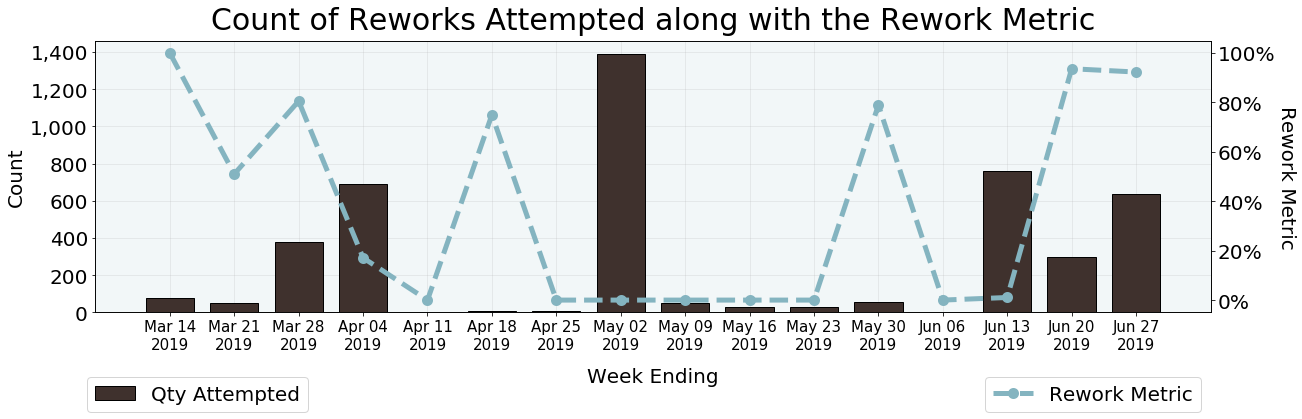

In [21]:
fig, ax = plt.subplots(figsize = (20,5))

n = 16 # plot the most recent 16 weeks
x = range(n)
y1 = rework['qty attempted'].tail(n)
y2 = rework['success %'].tail(n)

ax.bar(x, y1,
        edgecolor = 'black',
        width = 0.75,
        color = colors[1],
        label = 'qty attempted',
        zorder = 5)

ax.set_yticklabels(['{:,.0f}'.format(x) for x in ax.get_yticks()], fontsize = 20)
ax.set_ylabel('Count', fontsize = 20)
ax.set_title('Count of Reworks Attempted along with the Rework Metric', fontsize = 30, y = 1.02)
ax.legend(['Qty Attempted'], fontsize = 20, bbox_to_anchor = (0.2, -0.2))
ax.set_facecolor(colors[0])

ax2 = ax.twinx()
ax2.plot(x, y2,
       lw = 5,
       ls = '--',
       marker = 'o',
       mew = 5,
       color = colors[4],
       label = 'rework metric')

ax2.set_yticklabels(['{:,.0f}%'.format(x * 100) for x in ax2.get_yticks()], fontsize = 20)
ax2.set_ylabel('Rework Metric', fontsize = 20, rotation = 270, labelpad = 20)
ax2.legend(['Rework Metric'] ,fontsize = 20, bbox_to_anchor = (1, -0.2))
ax.grid(alpha = 0.25)
ax.set_xticks(x)
ls = list(qual.index[-n:])
ls2 = list(jb_dates(pd.Series(ls), 'date xticks'))
ax.set_xticklabels(ls2, fontsize = 15, rotation = 0)
ax.set_xlabel('Week Ending', fontsize = 20, labelpad = 15)

plt.savefig(image_path + ax.get_title(), bbox_inches = 'tight')
plt.show()

### Correlation

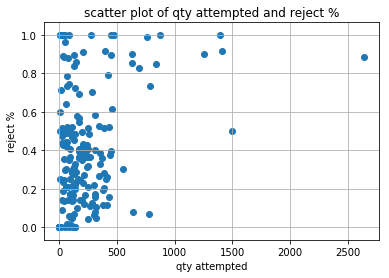

In [22]:
x = rework['qty attempted'].fillna(0)
y = rework['reject %'].fillna(0)
plt.scatter(x,y)
plt.ylabel('reject %')
plt.xlabel('qty attempted')
plt.title('scatter plot of qty attempted and reject %')
plt.grid()
plt.show()

### Reworks during current week

In [23]:
cur_reworks = reworks_main[reworks_main['spa week end'] == week_end].groupby(['part id','products name'])[['spa qty in','spa qty reject']].sum()
cur_reworks.columns = ['qty attempted','qty rejected']
cur_reworks['reject %'] = cur_reworks['qty rejected']/cur_reworks['qty attempted']
cur_reworks.sort_values('qty attempted', ascending = False, inplace = True)
cur_reworks.loc[('','column total'),('qty attempted','qty rejected')] = cur_reworks[['qty attempted','qty rejected']].sum()

ls = ['qty attempted','qty out','qty rejected']
if (rework.iloc[-1][ls] == 0).all():
    print('no reworks were performed during w/e {}'.format(week_end))
else:
    rej_per = cur_reworks.iloc[-1]['qty rejected']/cur_reworks.iloc[-1][['qty attempted']].sum()
    cur_reworks['reject %'].fillna(rej_per, inplace = True)
    display(cur_reworks.format_(['n0'] * 2 + ['p1']))

,,Qty Attempted,Qty Rejected,Reject %
part id,products name,,,
1500,Adafruit Trinket - Mini Microcontroller - 3.3V Logic,299,0,0.0%
1904,Adafruit Micro-Lipo Charger for LiPo/LiIon Batt w/MicroUSB Jack,84,3,3.6%
4062,Adafruit Feather nRF52840 Express,55,0,0.0%
1752,Stereo 20W Class D Audio Amplifier - MAX9744,38,0,0.0%
3061,Adafruit Feather M0 WiFi with uFL - ATSAMD21 + ATWINC1500,34,3,8.8%
3531,Adafruit 128x64 OLED Bonnet for Raspberry Pi,33,5,15.2%
2598,Adafruit Feather M0 WiFi - ATSAMD21 + ATWINC1500 (accounts only),31,4,12.9%
802,"Adafruit 1.8"" Color TFT Shield w/microSD and Joystick",25,5,20.0%
4000,Adafruit Metro M4 Express AirLift (WiFi) - Lite,16,16,100.0%


# In-Stock
In-Stock % = 1 - (Out of Stock / Total Stock)

In [24]:
# get all fab parts that are not outsourced and that are available to sell in the store
for_parts = pd.read_sql(
'''
SELECT
A.part_id,
LOWER(pd.products_name) AS products_name
FROM

(SELECT
part_id
FROM skus
WHERE bom_type = 'pnp' 
AND sku_outsourced_assembly != 1 
AND part_id != 0
GROUP BY part_id) A

JOIN parts p ON A.part_id = p.part_id
AND p.products_coming_soon = 0
AND p.discontinue_status NOT IN ('Discontinued')
AND p.products_meta_type NOT IN ('Base Product')
AND p.products_status = 1
AND p.products_dont_sell_alone = 0
AND p.products_virtual = 0

LEFT JOIN products_description pd ON p.part_id = pd.part_id
''', db)

col_fix(for_parts)

# create a list of these parts
parts = for_parts['part id'].tolist()

print('{:,.0f} fab parts will be considered'.format(len(parts)))

# get the first date to start from
date_start = str(np.min(fab_data_main['wo date created']).date())

# get stock data
stock_super_main = pd.read_sql(
'''
SELECT
DATE(timestamp) AS date,
part_id,
visible_stock
FROM parts_stock_snapshots
WHERE DATE(timestamp) BETWEEN ' '''+ date_start +''' ' AND ' '''+ week_end +''' '
AND part_id IN '''+ str(tuple(parts)) +'''
''', db)

col_fix(stock_super_main)

# this sql table is a snapshot of each part every 6 hours, so 4 per day
# get the average per part per day so we have just one number
stock_main = stock_super_main.groupby(['date','part id'], as_index = False)[['visible stock']].mean()

# round it
stock_main['visible stock'] = [int(np.round(x)) for x in stock_main['visible stock']]

# flag the skus and days in-stock
stock_main['in-stock'] = np.where(stock_main['visible stock'] <= 0, 0, 1)

# get additional date columns
stock_main['week ending'] = stock_main['date'].map(dict(zip(weeks['date'], weeks['week ending'])))

# get all the opportunities to be in stock
# this is (number of unique skus) * (days in a week)
# then get all the actual in stock counts
df1 = stock_main.groupby('week ending').agg({'in-stock':'sum','part id':['count','nunique']})
df1.columns = df1.columns.droplevel(0)

df1.rename(columns = {'sum':'agg in-stock',
                      'count':'agg sku count',
                      'nunique':'unique sku count'}, inplace = True)

# take the ratio to get % in stock and % out of stock
df1['in-stock %'] = df1['agg in-stock']/df1['agg sku count']

stock = df1.copy()

377 fab parts will be considered


### In-stock breakout

In [25]:
w = stock_main['week ending'].max()
df = stock_main[stock_main['week ending'] == w].copy()

df2 = df.groupby(['part id','date'])[['in-stock']].sum().unstack(1)
df2.columns = df2.columns.droplevel(0)
df2.fillna(0, inplace = True)

n = len(df2) # number of skus
d = len(df2.columns) # number of days in week
t = n*d # total number of opportunities to be out of stock, which is number of skus times days in week

df2['total days in-stock'] = df2.sum(1)

# add products names
ls1 = for_parts['part id']
ls2 = for_parts['products name']
ls3 = [a + ', ' +  b for a, b in zip(ls1.map(str), ls2)]
d = {k:v for k,v in zip(ls1, ls3)}

df2['part id, products name'] = df2.index.map(d)

# check nulls
nulls = df2[df2.isnull().any(1)]
if nulls.empty == False:
    print('check your nulls')
    
df2.reset_index(inplace = True)    

in_stock_breakout = df2.copy()

### Stock summary

In [26]:
fmt = ['n0'] * 3 + ['p1'] * 1

print(jb_mean(stock.iloc[-53:], fmt))

stock.tail(8).format_(fmt)

                   mean
Agg In-Stock      2,203
Agg Sku Count     2,422
Unique Sku Count    347
In-Stock %        91.1%


,Agg In-Stock,Agg Sku Count,Unique Sku Count,In-Stock %
week ending,,,,
2019-05-09,"2,341","2,597",371,90.1%
2019-05-16,"2,375","2,597",371,91.5%
2019-05-23,"2,350","2,600",372,90.4%
2019-05-30,"2,356","2,611",373,90.2%
2019-06-06,"2,298","2,611",373,88.0%
2019-06-13,"2,218","2,627",376,84.4%
2019-06-20,"2,240","2,639",377,84.9%
2019-06-27,"2,300","2,639",377,87.2%


### In-Stock plot

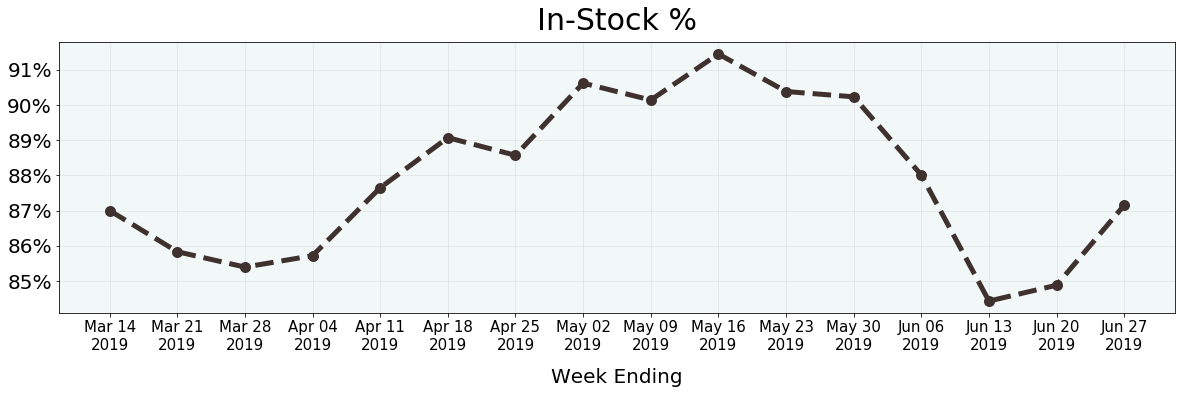

In [27]:
fig, ax = plt.subplots(figsize = (20,5))

n = 16 # plot the most recent 16 weeks
x = range(n)
y1 = stock['in-stock %'].tail(n)

ax.plot(x, y1,
       lw = 5,
       ls = '--',
       marker = 'o',
       mew = 5,
       color = colors[1])

ax.set_xticks(x)
ls = list(qual.index[-n:])
ls2 = list(jb_dates(pd.Series(ls), 'date xticks'))
ax.set_xticklabels(ls2, fontsize = 15, rotation = 0)
ax.set_xlabel('Week Ending', fontsize = 20, labelpad = 15)
ax.grid(alpha = 0.25)
ax.set_yticklabels(['{:,.0f}%'.format(x * 100) for x in ax.get_yticks()], fontsize = 20)
ax.set_title('In-Stock %', fontsize = 30, y = 1.02)
ax.legend().set_visible(False)
ax.set_facecolor(colors[0])

plt.savefig(image_path + ax.get_title(), bbox_inches = 'tight')
plt.show()

# Fab Op Metric
After getting each metric alone, let's put them altogether, weight them, and calculate the Fab Op Metric

In [28]:
# here are our weights, as determined by the Fab department
weights = {'availability':1.5/10,
           'quality'      :2/10,
           'rework'       :0.5/10, # least important = lowest weight
           'in-stock'     :6/10} # most important = heaviest weight

# check to make sure they sum to one
if sum(weights.values()) != 1:
    print('check this')

# get all metrics
df1 = avail[['availability %']]
df2 = qual[['quality %']]
df3 = rework[['success %']]
df4 = stock[['in-stock %']]

# join them all
df5 = df1.join(df2).join(df3).join(df4)

# rename columns and index
df5.columns = weights.keys()
df5.index.name = 'week ending'

# get each metric times its weight and then sum to get overall Fab Op Metric
df5['fab op metric'] = np.sum(df5 * list(weights.values()), axis = 1)
df5.fillna(0, inplace = True)

# get current week
df6 = df5.iloc[[-1]].T
df6.columns = ['week ending ' + week_end]

# get the avg
df7 = pd.DataFrame(df5.iloc[-53:].mean())
df7.columns = ['avg']

# get weights
df8 = pd.DataFrame.from_dict(weights, orient = 'index')
df8.columns = ['weight']

df9 = df6.join(df7).join(df8)

df9['above or below the avg'] = np.where(df9['week ending ' + week_end] < df9['avg'], 'below','ABOVE')

df10 = df9.copy()
df10.index = [x.title() for x in df10.index]
df10.reset_index(inplace = True)
df10.rename(columns = {'index':'metric'}, inplace = True)

fmt = [0] + ['p1'] * 3 + [0]
display(df10.format_(fmt).replace('nan%',''))
report_dict['summary - fab op metric table'] = df10.format_(fmt).replace('nan%','').to_html(index = False)

,Metric,Week Ending 2019-06-27,Avg,Weight,Above Or Below The Avg
0,Availability,70.6%,97.1%,15.0%,below
1,Quality,99.0%,99.3%,20.0%,below
2,Rework,92.3%,44.6%,5.0%,ABOVE
3,In-Stock,87.2%,91.1%,60.0%,below
4,Fab Op Metric,87.3%,91.3%,,below


### For State of the Fruit notes
For team leads to copy/paste into their notes for our weekly recurring company-wide meeting

In [29]:
last_week = str(df5.iloc[-2:].index[0].date())
this_week = str(df5.iloc[-2:].index[1].date())

ls = []
ls.append('fab ops!')
for i in df9.index:
    val1 = df5.loc[this_week][i] * 100
    val2 = df5.loc[last_week][i] * 100
    
    if i.title() == 'Fab Op Metric':
        val3 = df10[df10['metric'] == i.title()]['avg'].values[0] * 100
        i = 'overall'
        wrt = '-' + i + ': {:,.1f}% (last week: {:,.1f}%, goal = {:,.1f}%)'.format(val1, val2, val3)
        ls.append(wrt)
    else:    
        wrt = '-' + i + ': {:,.1f}% (last week: {:,.1f}%)'.format(val1, val2)
        ls.append(wrt)
    
report_dict['sotf blurb'] = '<br>'.join(ls)

print('\n'.join(ls))

fab ops!
-availability: 70.6% (last week: 67.7%)
-quality: 99.0% (last week: 99.6%)
-rework: 92.3% (last week: 93.6%)
-in-stock: 87.2% (last week: 84.9%)
-overall: 87.3% (last week: 85.7%, goal = 91.3%)


### Fab Op Plot

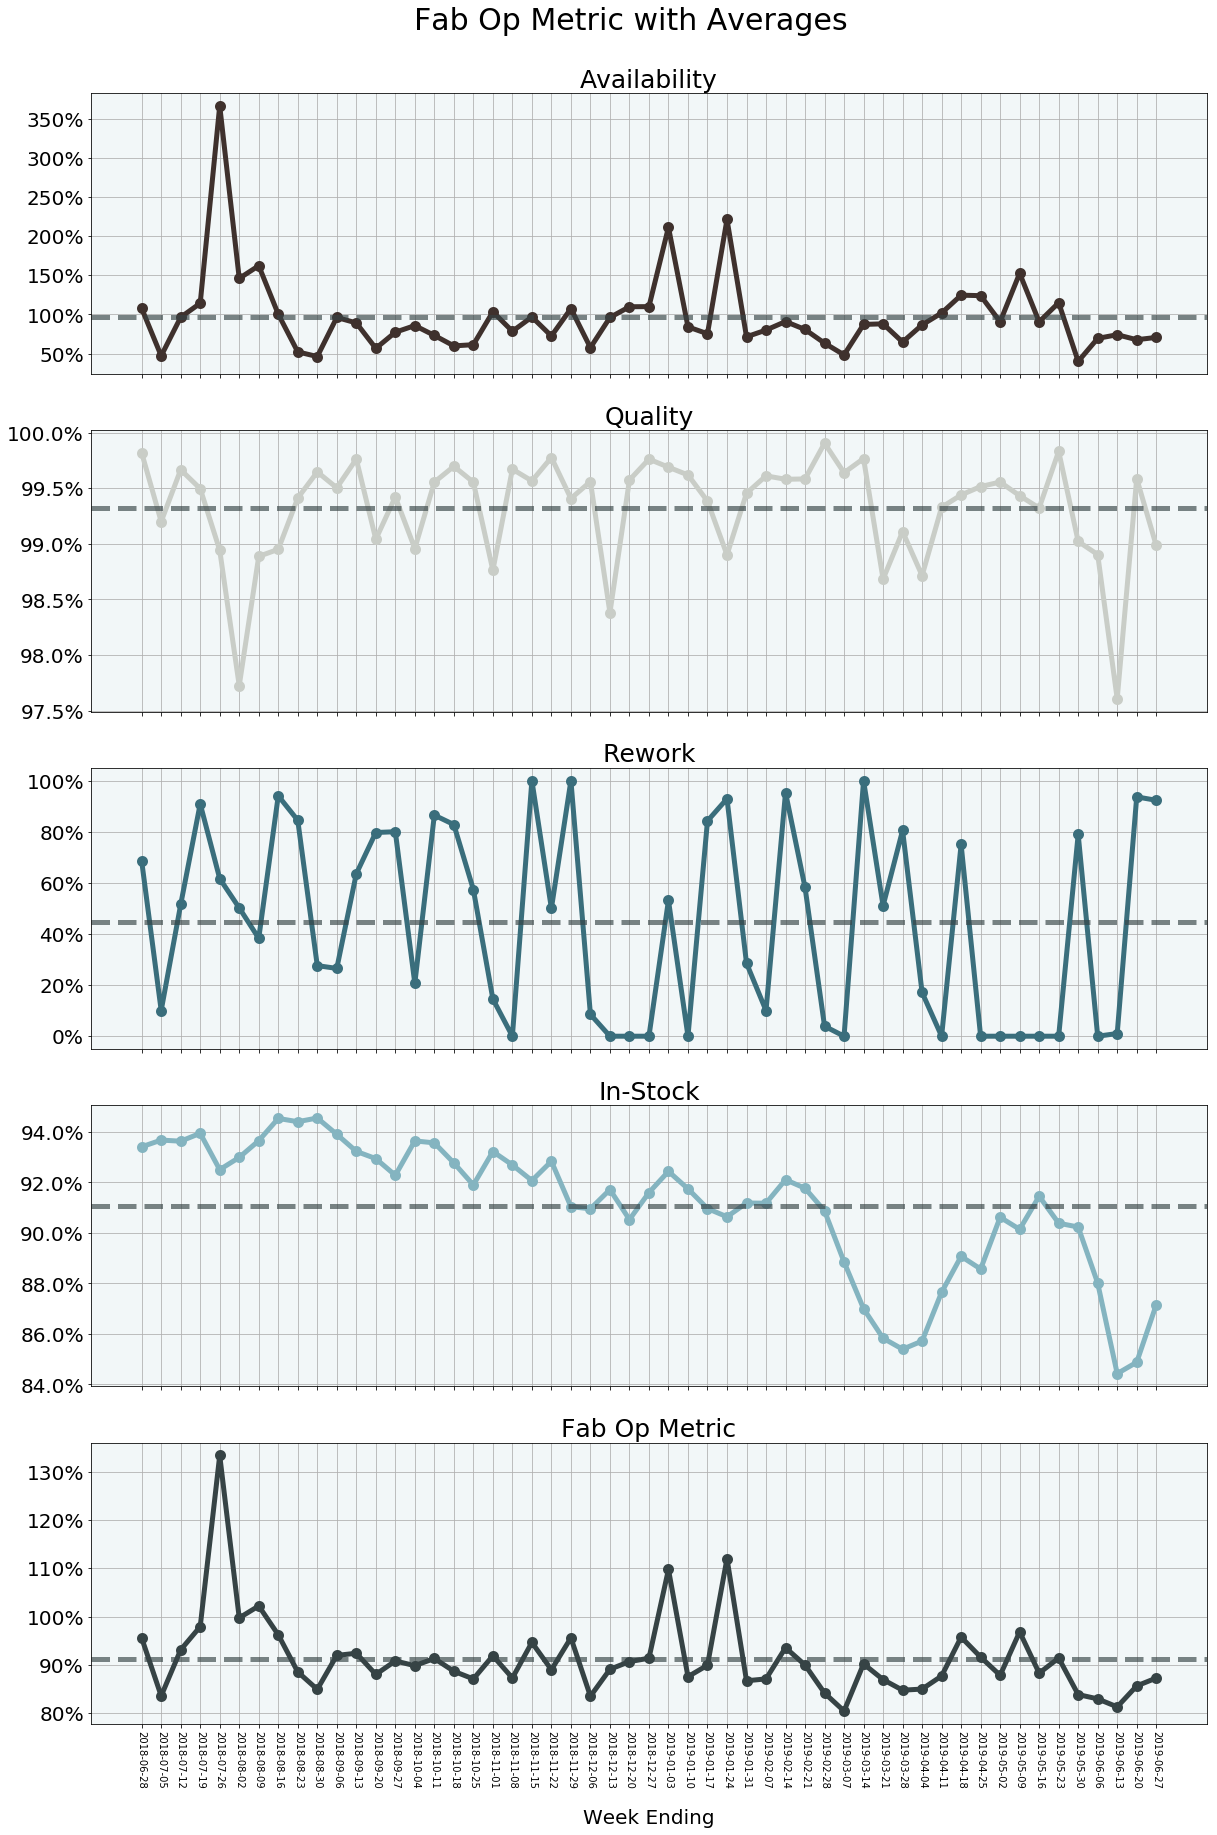

In [30]:
n = 53
chart = df5.iloc[-n:]
rows = len(chart.columns)

fig, axes = plt.subplots(nrows = rows, ncols = 1, figsize = (20,30))
for i in range(rows):
    x = range(n)
    y = chart[chart.columns[i]]
    axes[i].plot(x,y,
                 lw = 5,
                 marker = 'o',
                 mew = 5,
                 color = colors[i+1])
    axes[i].grid()
    axes[i].set_xticks(range(n))
    axes[i].set_facecolor(colors[0])
    
    name = chart.columns[i]
    if name in ['quality','in-stock']:
        p = '{:,.1f}%'
    else:
        p = '{:,.0f}%'
           
    axes[i].set_yticklabels([p.format(x * 100) for x in axes[i].get_yticks()], fontsize = 20)
    axes[i].legend().set_visible(False)
    axes[i].set_title(name.title(), fontsize = 25)
    axes[i].set_xticklabels('')
    
    m = df9.loc[name, 'avg']
    axes[i].axhline(m, ls = '--', color = colors[5], lw = 5, alpha = 0.65)
    
axes[i].set_xticks(range(n))
ls = [str(x) for x in chart.index.date]
axes[-1].set_xticklabels(ls, fontsize = 10, rotation = 270)    
axes[-1].set_xlabel('Week Ending', fontsize = 20, labelpad = 20)

title = 'Fab Op Metric with Averages'
plt.suptitle(title, fontsize = 30, y = 0.92)

fig.savefig(image_path + title, bbox_inches = 'tight')
plt.show()    

*****
# Excel
*****

### Set up workbook    

In [31]:
workbook = xlsxwriter.Workbook(csv_path + workbook_title + '.xlsx',
                               {'nan_inf_to_errors': True,
                               'strings_to_numbers': True})

tabs = ['Fab Op Table',
       'Completed',
       'Active',
       'Pending',
       'Completed Wos With Null Dates',
       'Parts Used for In-stock Metric',
       'In-stock Breakout',
       'Rejection Data',
       'Current Reworks']

#=========================
# Formats
#=========================

title = workbook.add_format({'font_size':25,
                             'font_name':'Arial (Bold)'})

subtitle = workbook.add_format({'font_size':15,
                                 'font_name':'Arial (Bold)'})


col_names = workbook.add_format({'font_name':'Arial (Bold)',
                                 'font_color':'white',
                                 'valign':'vcenter',
                                 'align':'center',
                                 'bg_color':colors[3],
                                 'bottom':1,
                                 'top':1,
                                 'left':1,
                                 'right':1})

percent = workbook.add_format({'num_format':'0.0%'})
number = workbook.add_format({'num_format':'#,##0'})
dummy = workbook.add_format({'font_color':'black'})
date = workbook.add_format({'num_format':'yyyy-mm-dd'})

for tab in tabs:
    workbook.add_worksheet(tab) # create each tab

my_worksheets = {}
for sht in workbook.worksheets():
    my_worksheets[sht.get_name()] = sht # create dict like tab_name:worksheet_instance

#=========================
# Apply same formatting to each worksheet
#=========================

for k, v in my_worksheets.items():
    sht = my_worksheets[k]
    sht.write(0, 0,
              k.title(),
              title)
    sht.write(1, 0,
              workbook_title,
              subtitle)

### Fab Op Table

In [32]:
sht = my_worksheets['Fab Op Table']

fmt = {'metric':dummy,
       'week ending ' + week_end:percent,
       'avg':percent,
       'weight':percent,
       'above or below the avg':dummy}

start_row = 3
start_col = 0

df = df10.copy()
df.replace([np.nan,np.inf], '', inplace = True)

for i in range(len(df.columns)):
    sht.write(start_row,
              start_col + i,
              df.columns[i].title(),
              col_names)

    len1 = [len(str(x)) for x in df.iloc[:, i]]
    len2 = [len(df.columns[i])]
    len3 = np.max(len1 + len2)

    sht.set_column(start_col + i,
                   start_col + i,
                   len3)

    for j in range(len(df)):
        sht.write(start_row + 1 + j, 
                  start_col + i,
                  df.iloc[j,i],
                  fmt[df.columns[i]])

### Completed, Active, Pending

In [33]:
cols = ['wo id',
       'wo id string',
       'wo date created',
       'wo date scheduled',
       'wo date active',
       'wo date completed',
       'sku id',
       'part id',
       'products name',
       'wo qty in',
       'wo qty out',
       'wo qty reject',
       'wo status',
       'wo substatus']


for_csv = fab_data_main[cols].drop_duplicates('wo id').copy()

In [34]:
for c in ['completed','active','pending']:
    
    sht = my_worksheets[c.title()]
    
    df = for_csv[for_csv['wo status'] == c].copy()   
    
    for col in ['created','scheduled','active','completed']:
        df['wo date ' + col] = pd.to_datetime(df['wo date ' + col])    
        
    df.replace([np.nan,np.inf], '', inplace = True)
    
    fmt = {'wo qty in':number,
           'wo qty out':number,
           'wo qty reject':number,
           
           'wo date created':date,
           'wo date active':date,
           'wo date scheduled':date,
           'wo date completed':date,}
    
    for i in range(len(df.columns)):
        sht.write(start_row,
                  start_col + i,
                  df.columns[i].title(),
                  col_names)

        len1 = [len(str(x)) for x in df.iloc[:, i]]
        len2 = [len(df.columns[i])]
        len3 = np.max(len1 + len2)

        sht.set_column(start_col + i,
                       start_col + i,
                       len3)

        for j in range(len(df)):
            sht.write(start_row + 1 + j, 
                      start_col + i,
                      df.iloc[j,i],
                      fmt[df.columns[i]] if df.columns[i] in list(fmt.keys()) else dummy)

### Completed Wos With Null Dates

In [35]:
sht = my_worksheets['Completed Wos With Null Dates']

df = date_nulls.iloc[:, :14]

for col in ['created','scheduled','active','completed']:
    df['wo date ' + col] = pd.to_datetime(df['wo date ' + col])    

df.replace([np.nan,np.inf], '', inplace = True)

fmt = {'wo qty in':number,
       'wo qty out':number,
       'wo qty reject':number,

       'wo date created':date,
       'wo date active':date,
       'wo date scheduled':date,
       'wo date completed':date,}

for i in range(len(df.columns)):
    sht.write(start_row,
              start_col + i,
              df.columns[i].title(),
              col_names)

    len1 = [len(str(x)) for x in df.iloc[:, i]]
    len2 = [len(df.columns[i])]
    len3 = np.max(len1 + len2)

    sht.set_column(start_col + i,
                   start_col + i,
                   len3)

    for j in range(len(df)):
        sht.write(start_row + 1 + j, 
                  start_col + i,
                  df.iloc[j,i],
                  fmt[df.columns[i]] if df.columns[i] in list(fmt.keys()) else dummy)

### Parts Used for In-stock Metric

In [36]:
sht = my_worksheets['Parts Used for In-stock Metric']

df = for_parts.copy()

for i in range(len(df.columns)):
    sht.write(start_row,
              start_col + i,
              df.columns[i].title(),
              col_names)

    len1 = [len(str(x)) for x in df.iloc[:, i]]
    len2 = [len(df.columns[i])]
    len3 = np.max(len1 + len2)

    sht.set_column(start_col + i,
                   start_col + i,
                   len3)

    for j in range(len(df)):
        sht.write(start_row + 1 + j, 
                  start_col + i,
                  df.iloc[j,i])

### Rejection data

In [37]:
sht = my_worksheets['Rejection Data']

df = rej2.copy()

c = df.columns.tolist()
f = [number] * len(c)
fmt = dict(zip(c,f))

df.reset_index(inplace = True)

for i in range(len(df.columns)):
    sht.write(start_row,
              start_col + i,
              df.columns[i].title(),
              col_names)

    len1 = [len(str(x)) for x in df.iloc[:, i]]
    len2 = [len(df.columns[i])]
    len3 = np.max(len1 + len2)

    sht.set_column(start_col + i,
                   start_col + i,
                   len3)

    for j in range(len(df)):
        sht.write(start_row + 1 + j, 
                  start_col + i,
                  df.iloc[j,i],
                  fmt[df.columns[i]] if df.columns[i] in list(fmt.keys()) else dummy)

### In-stock Breakout

In [38]:
in_stock_breakout.head(1)

date,part id,2019-06-21,2019-06-22,2019-06-23,2019-06-24,2019-06-25,2019-06-26,2019-06-27,total days in-stock,"part id, products name"
0,163,1,1,1,1,1,1,1,7,"163, adxl335 - 5v ready triple-axis accelerometer (+-3g analog out)"


In [39]:
sht = my_worksheets['In-stock Breakout']

df = in_stock_breakout.copy()

c = df.columns.tolist()
f = [dummy] + [number] * (len(df.columns)-2) + [dummy]
fmt = dict(zip(c,f))

for i in range(len(df.columns)):
    sht.write(start_row,
              start_col + i,
              str(df.columns[i]).title(),
              col_names)

    if df.columns[i] == 'part id, products name':
        length = df['part id, products name'].map(len).max()
    elif df.columns[i] == 'total days in-stock':
        length = 25
    else:
        length = 10
        
    sht.set_column(start_col + i,
                   start_col + i,
                   length)

    for j in range(len(df)):
        sht.write(start_row + 1 + j, 
                  start_col + i,
                  df.iloc[j,i],
                  fmt[df.columns[i]] if df.columns[i] in list(fmt.keys()) else dummy)

### Current Reworks

In [40]:
sht = my_worksheets['Current Reworks']

df = cur_reworks.copy()
df.reset_index(inplace = True)

fmt = {'qty attempted':number,
       'qty rejected':number,
       'reject %':percent}

for i in range(len(df.columns)):
    sht.write(start_row,
              start_col + i,
              df.columns[i].title(),
              col_names)

    len1 = [len(str(x)) for x in df.iloc[:, i]]
    len2 = [len(df.columns[i])]
    len3 = np.max(len1 + len2)

    sht.set_column(start_col + i,
                   start_col + i,
                   len3)

    for j in range(len(df)):
        sht.write(start_row + 1 + j, 
                  start_col + i,
                  df.iloc[j,i],
                  fmt[df.columns[i]] if df.columns[i] in list(fmt.keys()) else dummy)

In [41]:
if workbook_close == 'yes':
    workbook.close()

# Time from WO creation to completion

In [42]:
six_months_ago = str((pd.to_datetime(week_end) - pd.DateOffset(months = 6)).date())

# choose your columns

ls = ['wo id',
      'wo date created',
      'wo date scheduled',
      'wo date active',
      'wo date completed',
      'process time start',
      'process time end',
      'spa time start',
      'spa time end']

# exclude outsourced and get only completed WOs
for_time = fab_data_main[(fab_data_main['wo outsourced'] == 'no')
              & (fab_data_main['wo status'] == 'completed')][ls].copy()

# change to datetime
for col in ['created','scheduled','active','completed']:
    for_time['wo date ' + col] = pd.to_datetime(for_time['wo date ' + col], errors = 'coerce')
    
# get data from 6 months ago only    
for_time = for_time[for_time['wo date completed'] >= six_months_ago].copy()

# create to scheduled
df1 = for_time.drop_duplicates('wo id').copy()
df1['created to scheduled'] = (df1['wo date scheduled'] - df1['wo date created']).dt.days * 86400
df1['created to scheduled'].dropna(inplace = True)

# scheduled to active
df2 = for_time.drop_duplicates('wo id').copy()
df2['scheduled to active'] = (df2['wo date active'] - df2['wo date scheduled']).dt.days * 86400

# active to completed
df3 = for_time.drop_duplicates('wo id').copy()
df3['active to completed'] = (df2['wo date completed'] - df2['wo date active']).dt.days * 86400

# put it all together
by_wo = pd.merge(df1[['wo id','created to scheduled']],
                 df2[['wo id','scheduled to active']],
                 how = 'left',
                 on = 'wo id').merge(df3[['wo id','active to completed']],
                                    how = 'left',
                                    on = 'wo id')

# map the week completed
by_wo['wo week completed'] = by_wo['wo id'].map(dict(zip(fab_data_main['wo id'], fab_data_main['wo week completed'])))
by_wo.sort_values('wo week completed', inplace = True)

t = len(by_wo[by_wo['wo week completed'] == week_end])

print('x{} work orders were completed during week ending {}.'.format(t, week_end))

# avg time elapsed per WO for the latest week
a = pd.DataFrame(by_wo[by_wo['wo week completed'] == week_end].drop(['wo id','wo week completed'], 1).mean()/86400)

d = week_end
y = d[:4]
m = calendar.month_abbr[int(d[5:7])]
dy = d[-2:]

per = 'week ending ' + m + ' ' + dy + ', ' + y     
a.columns = [per]

# avg time elapsed per WO for all weeks in the last 6 months
b = pd.DataFrame(by_wo.drop(['wo id','wo week completed'], 1).mean()/86400)
b.columns = ['6 month avg']

c = a.join(b)
c.index.names = ['Period']
c.index = [x.title() for x in c.index]

for col in c.columns:
    c[col] = [int(np.round(x)) for x in c[col]]
    
ls = []
for index, row in c.iterrows():
    if np.abs(row[0] - row[1]) < 2:
        ret = 'About Equal'
    else:
        if row[0] < row[1]:
            ret = 'Shorter'
        else:
            ret = 'Longer'
    ls.append(ret)
    
c['shorter or longer than avg?'] = ls    

c.columns = c.columns.str.title()

print('The table below is the avg time, per work order, that it takes to go from period to period (measured in days)')
display(c)

report_dict['wo times table'] = c.to_html(index = True)

x24 work orders were completed during week ending 2019-06-27.
The table below is the avg time, per work order, that it takes to go from period to period (measured in days)


,"Week Ending Jun 27, 2019",6 Month Avg,Shorter Or Longer Than Avg?
Created To Scheduled,66,54,Longer
Scheduled To Active,0,1,About Equal
Active To Completed,58,42,Longer


*****
# PDF report
*****

In [43]:
ls1 = ['came to',
      'amounted to',
      'reached',
      'totaled',
      'equalled',
      'arrived at',
      'achieved']

ls2 = ['above',
      'higher',
      'greater than',
      'larger than',
      'surpassing',
      'passing',
      'exceeding']

ls3 = ['below',
      'under',
      'less than',
      'beneath',
      'underneath',
      'lower than',
      'short of']

ls4 = ['about equal to']

### Report Availability

In [44]:
i = np.random.randint(len(ls1))

a = int(avail.iloc[-1]['scheduled'])
b = int(avail.iloc[-1]['active'])
c = int(avail.iloc[-1]['completed'])

cur = avail.iloc[-1]['availability %']
avg = df10[df10['metric'] == 'Availability']['avg'].values[0]

if np.abs(cur - avg) <= 0.01:
    w = 'about equal to'
else:
    if cur < avg:
        w = ls3[i]
    else:
        w = ls2[i]

wrt1 = 'This metric {} {:,.1f}%, {} the average of {:,.1f}%.'.format(ls1[i], cur * 100, w, avg * 100)
wrt2 = 'x{} work orders were scheduled, x{} went active, and x{} were completed. \
The chart below shows these counts over time along with the Availability Metric.'.format(a,b,c)

report_dict['avail - summary write'] = wrt1 + ' ' + wrt2

### Report Quality

In [45]:
i = np.random.randint(len(ls1))

cur = qual.iloc[-1]['quality %']
avg = df10[df10['metric'] == 'Quality']['avg'].values[0]

if np.abs(cur - avg) <= 0.01:
    w = 'about equal to'
else:
    if cur < avg:
        w = ls3[i]
    else:
        w = ls2[i]

wrt = 'This metric {} {:,.1f}%, {} the average of {:,.1f}%.'.format(ls1[i], cur * 100, w, avg * 100)
report_dict['quality - summary write'] = wrt

### Report Machine Yield

In [46]:
i = np.random.randint(len(ls1))

cur = qual.iloc[-1]['machine yield']
avg = qual['machine yield'].mean()

if np.abs(cur - avg) <= 0.001:
    w = 'about equal to'
else:
    if cur < avg:
        w = ls3[i]
    else:
        w = ls2[i]

wrt = 'Zooming in now to the Fabrication step, we have Machine Yield, which {} {:,.1f}%, {} the average of \
{:,.1f}%.'.format(ls1[i], cur * 100, w, avg * 100)
report_dict['quality - machine yield write'] = wrt

### Report Rework

In [47]:
i = np.random.randint(len(ls1))

cur = rework.iloc[-1]['success %']
avg = df10[df10['metric'] == 'Rework']['avg'].values[0]

if np.abs(cur - avg) <= 0.01:
    w = 'about equal to'
else:
    if cur < avg:
        w = ls3[i]
    else:
        w = ls2[i]
        
a = int(rework.iloc[-1]['qty attempted'])
b = int(rework.iloc[-1]['qty out'])
        
if a == 0:
    add = ', because no reworks were attempted.'
else:
    add = '. x{:,.0f} units were attempted and x{:,.0f} were successful.'.format(a,b)

wrt = 'This metric {} {:,.1f}%, {} the average of {:,.1f}%'.format(ls1[i], cur * 100, w, avg * 100) + add
report_dict['rework - summary write'] = wrt

### Report In-Stock

In [48]:
i = np.random.randint(len(ls1))

unique_sku_count = int(stock.iloc[-1]['unique sku count'])
report_dict['in-stock - unique sku count'] = unique_sku_count

cur = stock.iloc[-1]['in-stock %']
avg = df10[df10['metric'] == 'In-Stock']['avg'].values[0]

if np.abs(cur - avg) <= 0.01:
    w = 'about equal to'
else:
    if cur < avg:
        w = ls3[i]
    else:
        w = ls2[i]
        
wrt = 'This metric {} {:,.1f}%, {} the average of {:,.1f}%, and below is a chart showing this metric over time.'.format(ls1[i], cur * 100, w, avg * 100)        
report_dict['in-stock - summary write'] = wrt

# PDF Start

In [49]:
if pdf_write == 'yes':
    
    data_link = 'https://www.dropbox.com/sh/st80djvfp77ccbd/AAAh8mXioFzdi1_zhZq2N7Tqa?dl=0'
    report_title = 'w.e. ' + week_end + ' - Fab Op Report.pdf'        
    
    from jinja2 import Environment, FileSystemLoader
    env = Environment(loader = FileSystemLoader(html_path))

    template = env.get_template(html_title)

    template_vars = {'week_end':week_end,
                     'now':pretty_now,
                     
                     'summary_fab_op_metric_table':report_dict['summary - fab op metric table'],
                     'data_link':data_link,
                     
                     'sotf_blurb':report_dict['sotf blurb'],
                     
                     'summary_work_order_counts':report_dict['summary - work order counts'],
                     'avail_summary_write':report_dict['avail - summary write'],
                    
                     'quality_summary_write':report_dict['quality - summary write'],
                     'quality_high_rejection_write':report_dict['quality - high rejection write'],
                    
                     'quality_machine_yield_write':report_dict['quality - machine yield write'],
                    
                     'rework_summary_write':report_dict['rework - summary write'],
                    
                     'unique_sku_count':report_dict['in-stock - unique sku count'],
                     'in_stock_summary_write':report_dict['in-stock - summary write'],
                    
                     'wo_times_table':report_dict['wo times table'],
                    
                     'tilde':tilde}

    html_out = template.render(template_vars)

    from weasyprint import HTML
    HTML(string = html_out).write_pdf(pdf_path + report_title,
                                      stylesheets = [style_sheet_path])                               

In [50]:
print('done')

done
